# Exemples d'utilisation du réseau de neurones 
Ce notebook charge le réseau que nous avons préalablement entrainé. (state_dict_model.pt). Et on peut ensuite s'en servir.

In [1]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import data

In [2]:
data = data.Data(100, "apple.csv")

(2325, 100)


In [3]:
PATH = "state_dict_model.pt"
model = torch.load(PATH) #on charge le réseau de neurones premièrement entrainé 

In [4]:
def generator_return_func():
    """La fonction renvoie un return généré par le réseau"""
    noise = torch.randn((1,1,100))
    return np.squeeze(model(noise)).detach().numpy()

In [5]:
def generator_return_focus(noise):
    """La fonction renvoie un return généré par le réseau"""
    
    return np.squeeze(model(noise)).detach().numpy()

In [6]:
def simuler_cours_apple(p0):
    """p0 : prix de départ 
    La fonction prend un prix de départ et renvoie les cours de Apple (240 cours), à partir du prix initial"""
    return data.post_processing(generator_return_func(),p0)

In [7]:
def simuler_cours_apple_focus(p0,noise):
    """p0 : prix de départ 
    La fonction prend un prix de départ et renvoie les cours de Apple (240 cours), à partir du prix initial"""
    return data.post_processing(generator_return_focus(noise),p0)

In [8]:
def obtenir_traj_reelle():
    out = data.get_single_sample()
    out = data.post_processing(np.squeeze(out[0]).numpy(),out[1])
    return out

# Exemple 

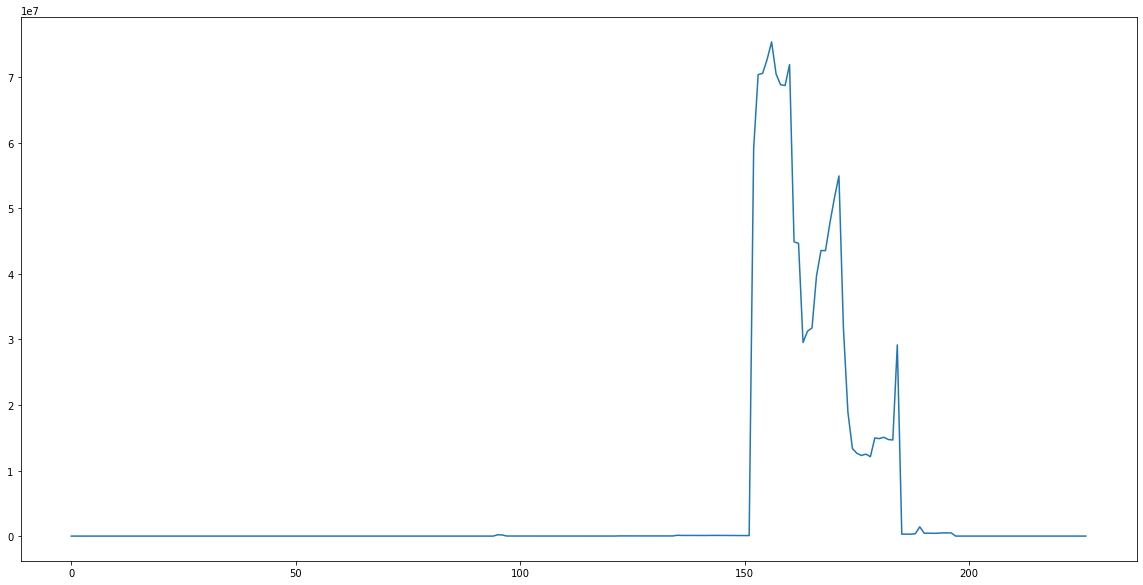

In [22]:
plt.figure(figsize=(20,10))
plt.plot(simuler_cours_apple(20))

## Visulalisation de la déformation des trajectoires 

<AxesSubplot:>

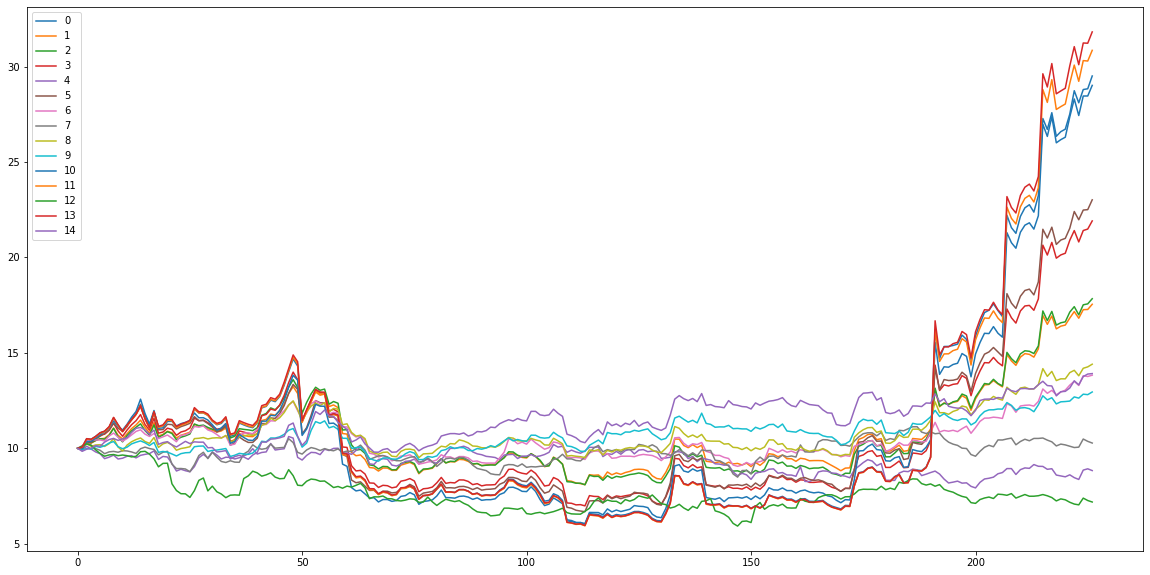

In [30]:
df = pd.DataFrame()
noise = torch.randn((1,1,100))
for i in range(15):
    noise2 = noise
    noise2[:,:,-10:] = torch.randn((1,1,10))
    df[i] = simuler_cours_apple_focus(10,noise2)
df.plot(figsize=(20,10))

<AxesSubplot:>

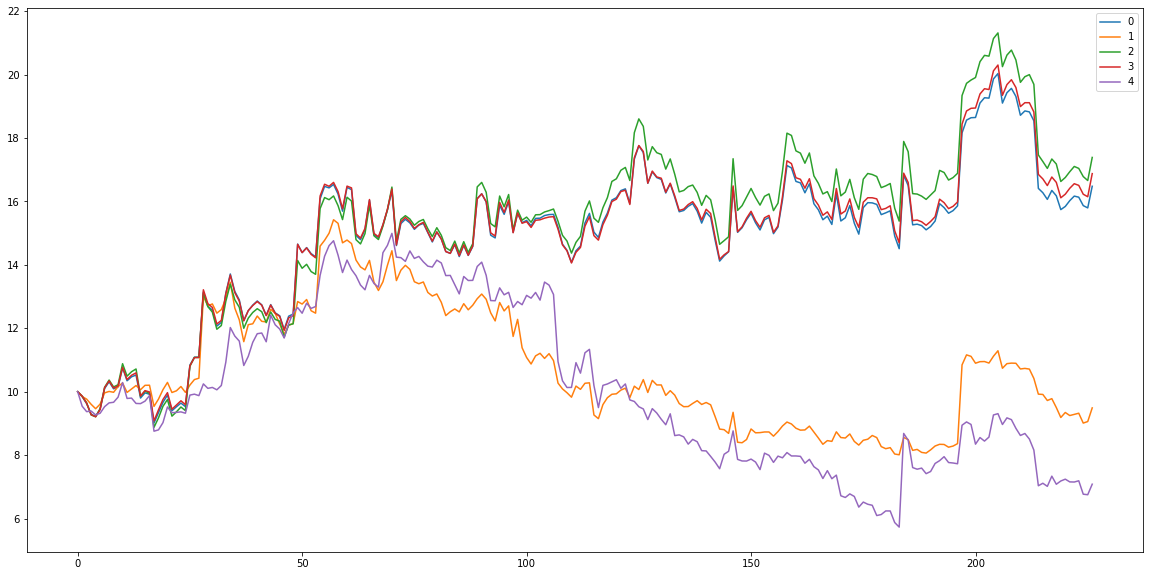

In [38]:
df = pd.DataFrame()
noise = torch.randn((1,1,100))
for i in range(5):
    noise2 = noise
    noise2[:,:,-10:] = torch.randn((1,1,10))
    df[i] = simuler_cours_apple_focus(10,noise2)
itv_conf = pd.DataFrame()
#itv_conf['itv_sup']= df.mean(axis=1) + 1.96*df.var(axis=1)
#itv_conf['itv_inf']= df.mean(axis=1) - 1.96*df.var(axis=1)
#itv_conf['mean']= df.mean(axis=1)

#itv_conf.plot(figsize=(20,10))
df.plot(figsize=(20,10))

# Analyses 
On peut vérifier que les rendements ne sont pas totalement indépendants 

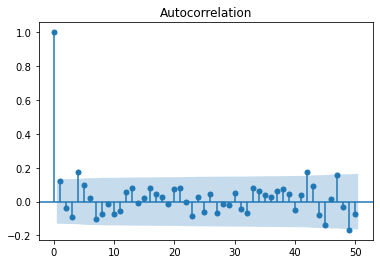

In [39]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
# Use the Autocorrelation function
# from the statsmodel library passing
# our DataFrame object in as the data
# Note: Limiting Lags to 50
plot_acf(x=np.diff(simuler_cours_apple(100)), lags=50)
# Show the AR as a plot
plt.show()


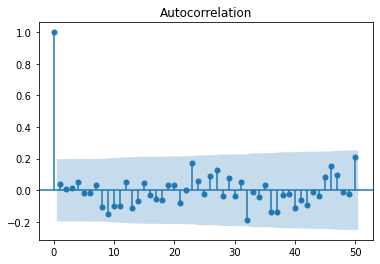

In [40]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
# Use the Autocorrelation function
# from the statsmodel library passing
# our DataFrame object in as the data
# Note: Limiting Lags to 50
plot_acf(x=np.diff(obtenir_traj_reelle()), lags=50)
# Show the AR as a plot
plt.show()



In [41]:
from scipy.stats import kurtosis
from scipy.stats import skew

test = simuler_cours_apple(100)
print("\n On a sur le réseau de neurones que : ")
print("la symétrie est de :",skew(test, bias=False)) #symétrie 
print("l'épaisseur de la queue est :", kurtosis(test, bias=False))


print("\n 0n a sur ds cours réels que : ")
real = obtenir_traj_reelle()
print("la symétrie est de :",skew(real, bias=False)) #symétrie 
print("l'épaisseur de la queue est :", kurtosis(real, bias=False))


 On a sur le réseau de neurones que : 
la symétrie est de : 1.2213402508246316
l'épaisseur de la queue est : 2.703769569379311

 0n a sur ds cours réels que : 
la symétrie est de : 0.5230126447286726
l'épaisseur de la queue est : -0.7589189689170599
